In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import os
from datasets import load_processed_data

Loading data in chunks of 500: 100%|██████████| 37745/37745.0 [06:02<00:00, 104.21it/s] 


Loaded 18872499 rows
Loading data from 'c:\Users\eva\Documents\Master\MA1\ADA2024\ada-2024-project-ooohfada\data\yt_metadata_helper.feather'...


ArrowMemoryError: malloc of size 17179869184 failed

In [70]:
import sys
# Local Modules
sys.path.insert(0, '../')

df = pd.read_csv("C:/Users/eva/Documents/Master/MA1/ADA2024/ada-2024-project-ooohfada/data/df_bb_data_en_processed.tsv", sep="\t", compression='infer')
print(df.head())
print(df.size)
print("there are", df['channel'].nunique(), "channels and", df.shape[0], "entries")
print(df.shape)
print(df['channel'].unique())

                    channel  week category         views   delta_views  \
0  UC-lHJZR3Gqxm24_Vd_AJ5Yw    93   Gaming  1.357761e+10           NaN   
1  UC-lHJZR3Gqxm24_Vd_AJ5Yw    94   Gaming  1.368959e+10  1.119836e+08   
2  UC-lHJZR3Gqxm24_Vd_AJ5Yw    95   Gaming  1.373594e+10  4.635159e+07   
3  UC-lHJZR3Gqxm24_Vd_AJ5Yw    96   Gaming  1.376195e+10  2.600902e+07   
4  UC-lHJZR3Gqxm24_Vd_AJ5Yw    97   Gaming  1.378603e+10  2.407718e+07   

           subs     delta_subs  videos  delta_videos  activity  view_count  \
0  4.861796e+07            NaN    2906           NaN        14  45210757.0   
1  4.897182e+07  353856.680699    2919          13.0        15  40885232.0   
2  4.909397e+07  122152.626592    2926           7.0        15  27707359.0   
3  4.917638e+07   82404.010417    2932           6.0        14  25489724.0   
4  4.925474e+07   78360.625000    2934           2.0         9  10034755.0   

   like_count  dislike_count  
0   1892943.0        51248.0  
1   2018614.0        355

In [29]:
from ipywidgets import interact, SelectionSlider

df_l = df
df_l['like_ratio'] = df_l['like_count'] / (df_l['like_count'] + df_l['dislike_count'])


def plot_channel(channel):
    fig, ax1 = plt.subplots(figsize=(15, 5))
    
    # Plot for the subscriber count
    sns.lineplot(
        data=df_l[df_l['channel'] == channel], 
        x='week', 
        y='subs', 
        ax=ax1, 
        label='Subscribers',
        color='blue'
    )
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Subscribers", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Plot for the like ratio
    ax2 = ax1.twinx()
    sns.lineplot(
        data=df_l[df_l['channel'] == channel], 
        x='week', 
        y='like_ratio', 
        ax=ax2, 
        label='Like Ratio',
        color='green'
    )
    ax2.set_ylabel("Like Ratio", color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.set_ylim(0, 1) 

    plt.title(f"Trends for {channel}")
    fig.tight_layout() 
    plt.show()

# Create an interactive dropdown
interact(plot_channel, channel=SelectionSlider(options = df['channel'], description='Channel:'), continuous_update=False)

interactive(children=(SelectionSlider(description='Channel:', options=('UC-lHJZR3Gqxm24_Vd_AJ5Yw', 'UC-lHJZR3G…

<function __main__.plot_channel(channel)>

### Rolling growth rate
This metric uses a rolling average of growth rates over a defined window (e.g., 26 weeks or a year). The rolling window helps smooth out short-term fluctuations and identifies long-term trends.

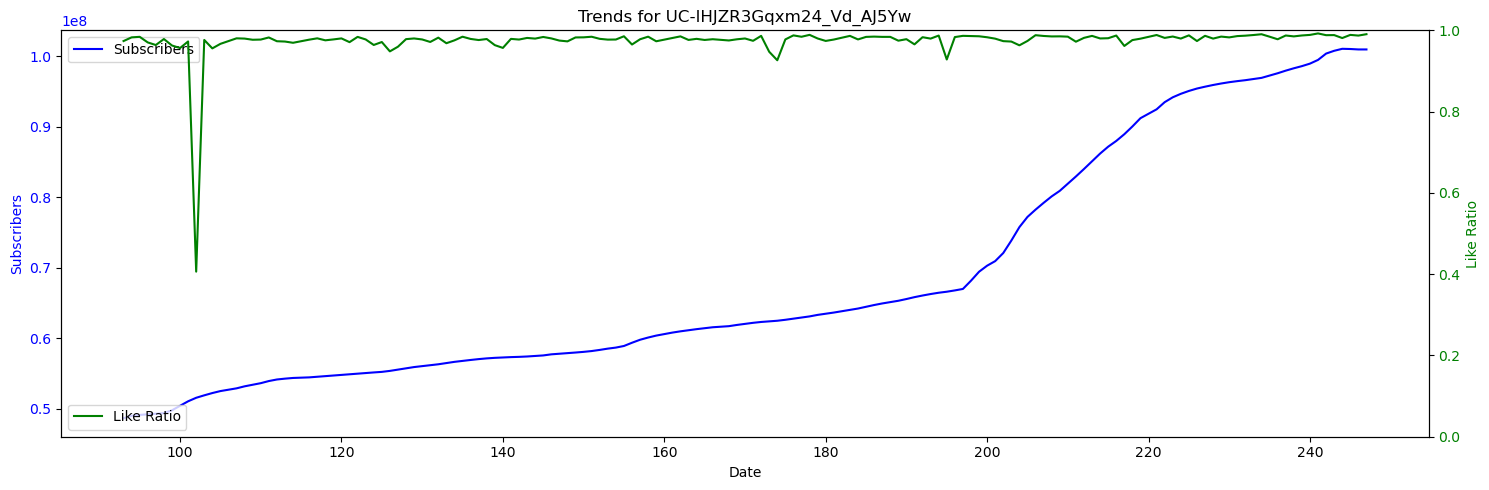

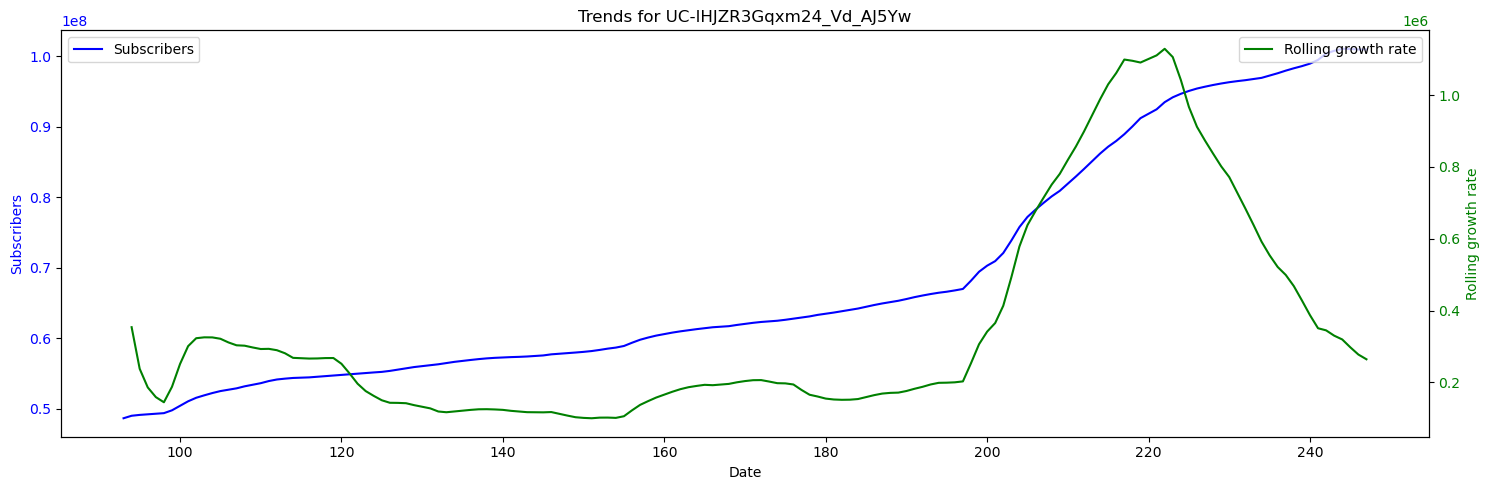

In [57]:
# Calculate a rolling mean for the growth rate (e.g., 26 weeks)
df_l['rolling_growth_rate'] = df_l.groupby('channel')['delta_subs'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())

def plot_rolling_gr(channel):
    fig, ax1 = plt.subplots(figsize=(15, 5))
    
    # Plot for the subscriber count
    sns.lineplot(
        data=df_l[df_l['channel'] == channel], 
        x='week', 
        y='subs', 
        ax=ax1, 
        label='Subscribers',
        color='blue'
    )
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Subscribers", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Plot for the like ratio
    ax2 = ax1.twinx()
    sns.lineplot(
        data=df_l[df_l['channel'] == channel], 
        x='week', 
        y='rolling_growth_rate', 
        ax=ax2, 
        label='Rolling growth rate',
        color='green'
    )
    ax2.set_ylabel("Rolling growth rate", color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    plt.title(f"Trends for {channel}")
    fig.tight_layout() 
    plt.show()


df_l['log_subs'] = np.log1p(df_l['subs'])
df_l['log_growth_rate'] = df_l['log_subs'].diff()


channel = 'UC-lHJZR3Gqxm24_Vd_AJ5Yw'
plot_channel(channel)
plot_rolling_gr(channel)

### Detect potential bad buzz
When the actual growth rate (delta subs) < rolling growth rate.

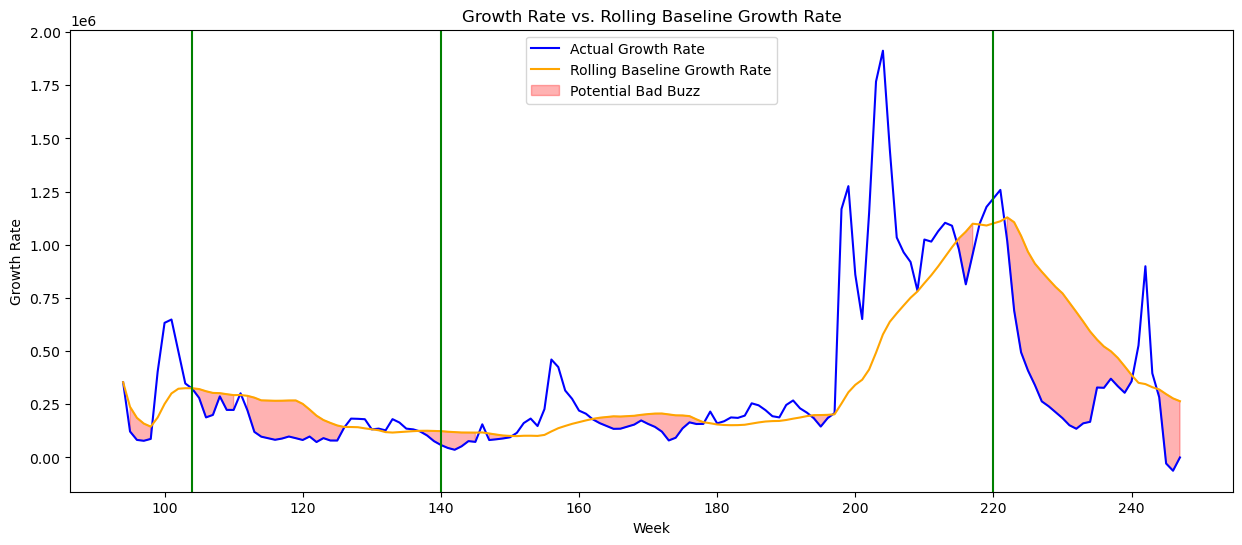

In [65]:
pewdiepie = df_l[df_l['channel'] == 'UC-lHJZR3Gqxm24_Vd_AJ5Yw']

plt.figure(figsize=(15, 6))
plt.plot(pewdiepie['week'], pewdiepie['delta_subs'], label='Actual Growth Rate', color='blue')
plt.plot(pewdiepie['week'], pewdiepie['rolling_growth_rate'], label='Rolling Baseline Growth Rate', color='orange')
plt.fill_between(pewdiepie['week'], pewdiepie['delta_subs'], pewdiepie['rolling_growth_rate'], 
                 where=(pewdiepie['delta_subs'] < pewdiepie['rolling_growth_rate']), 
                 color='red', alpha=0.3, label='Potential Bad Buzz')

plt.axvline(x = 140, color = 'green')
plt.axvline(x = 104, color = 'green')
plt.axvline(x = 220, color = 'green')


plt.xlabel('Week')
plt.ylabel('Growth Rate')
plt.title('Growth Rate vs. Rolling Baseline Growth Rate')
plt.legend()
plt.show()


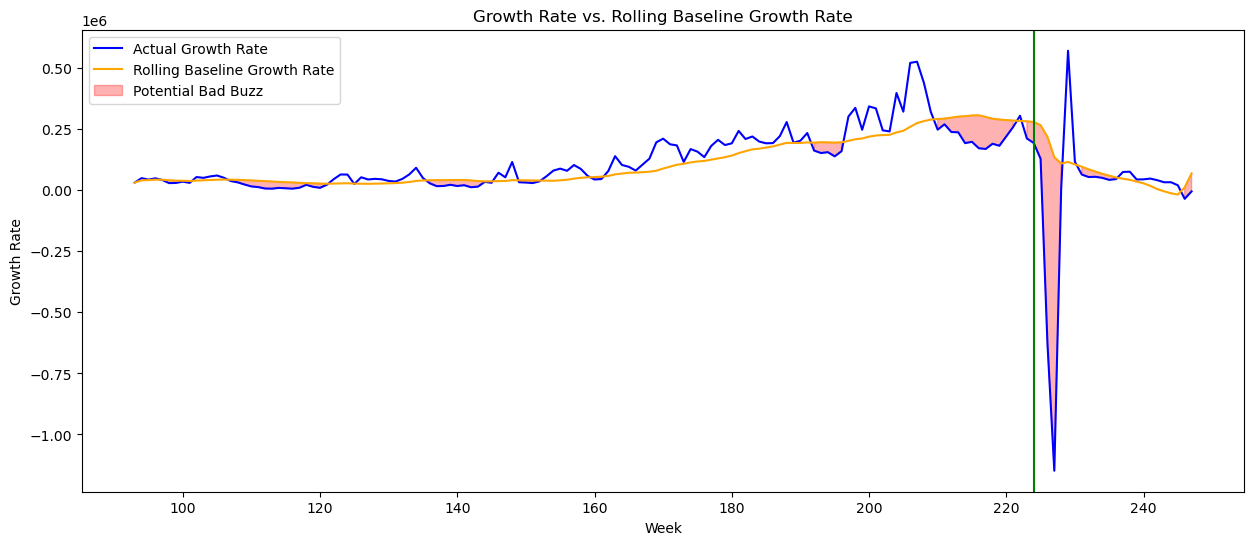

In [68]:
james_charles = df_l[df_l['channel'] == 'UCucot-Zp428OwkyRm2I7v2Q']

plt.figure(figsize=(15, 6))
plt.plot(james_charles['week'], james_charles['delta_subs'], label='Actual Growth Rate', color='blue')
plt.plot(james_charles['week'], james_charles['rolling_growth_rate'], label='Rolling Baseline Growth Rate', color='orange')
plt.fill_between(james_charles['week'], james_charles['delta_subs'], james_charles['rolling_growth_rate'], 
                 where=(james_charles['delta_subs'] < james_charles['rolling_growth_rate']), 
                 color='red', alpha=0.3, label='Potential Bad Buzz')

plt.axvline(x = 224, color = 'green')


plt.xlabel('Week')
plt.ylabel('Growth Rate')
plt.title('Growth Rate vs. Rolling Baseline Growth Rate')
plt.legend()
plt.show()

In [ ]:
UCcgVECVN4OKV6DH1jLkqmcA # Jake Paul

In [81]:
def potential_bb(channel, bb=None ):
    c = df_l[df_l['channel'] == channel]

    plt.figure(figsize=(15, 6))
    plt.plot(c['week'], c['delta_subs'], label='Actual Growth Rate', color='blue')
    plt.plot(c['week'], c['rolling_growth_rate'], label='Rolling Baseline Growth Rate', color='orange')
    plt.fill_between(c['week'], c['delta_subs'], c['rolling_growth_rate'], 
                    where=(c['delta_subs'] < c['rolling_growth_rate']), 
                    color='red', alpha=0.3, label='Potential Bad Buzz')
    if bb is not None and len(bb) > 0:
        for el in bb:
            plt.axvline(x = el, color = 'green')

    plt.xlabel('Week')
    plt.ylabel('Growth Rate')
    plt.title('Growth Rate vs. Rolling Baseline Growth Rate')
    plt.legend()
    plt.show()

interact(potential_bb, channel=SelectionSlider(options = df['channel'], description='Channel:'), continuous_update=False, bb=[])

interactive(children=(SelectionSlider(description='Channel:', options=('UC-lHJZR3Gqxm24_Vd_AJ5Yw', 'UC-lHJZR3G…

<function __main__.potential_bb(channel, bb=None)>

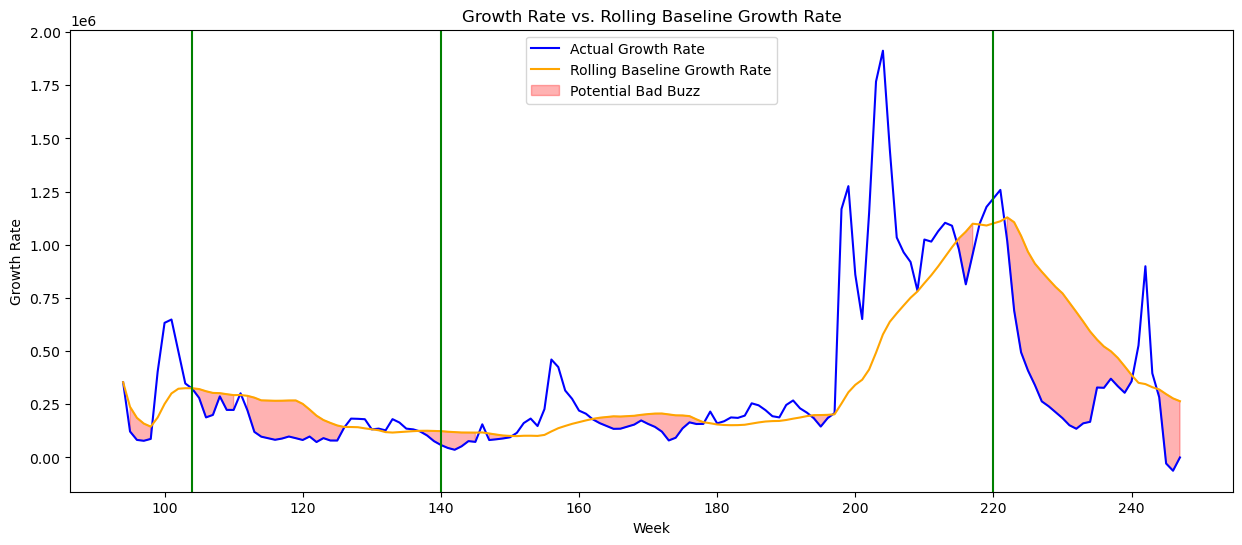

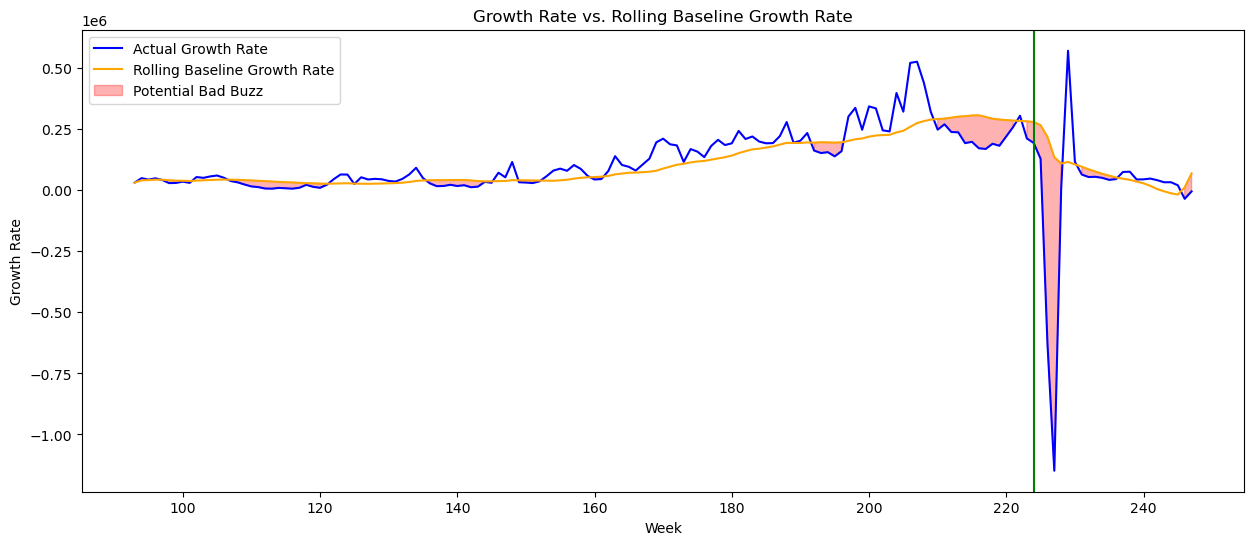

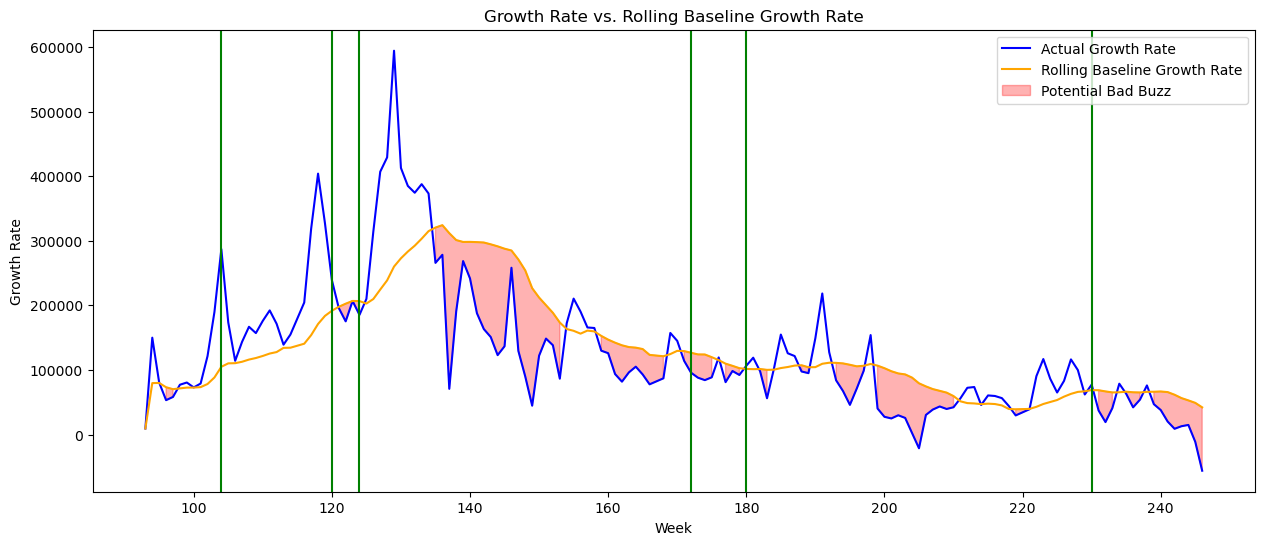

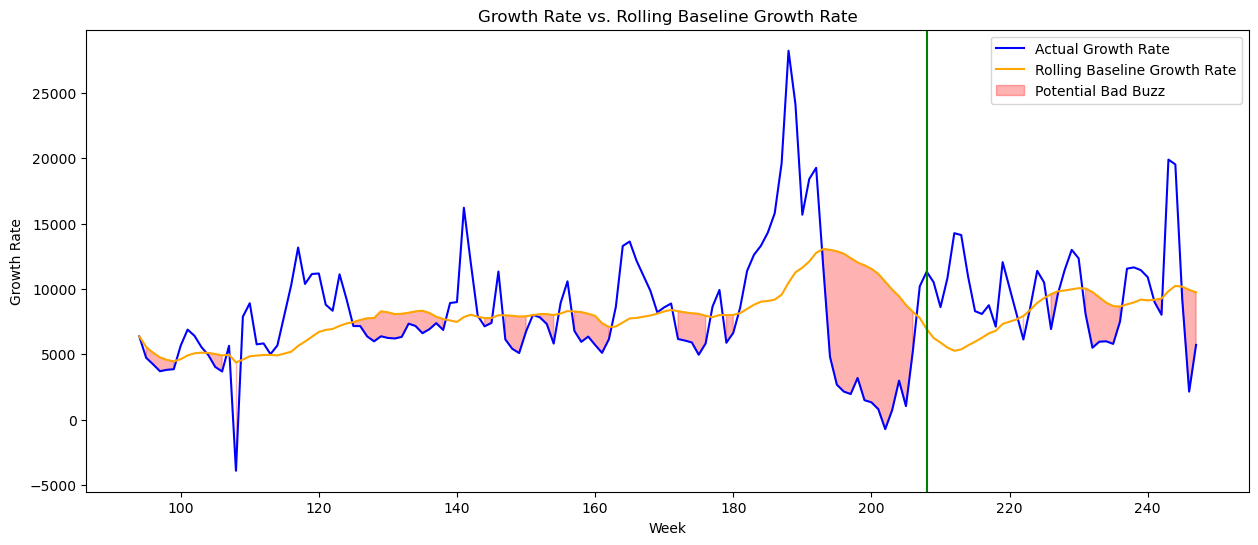

In [99]:
potential_bb('UC-lHJZR3Gqxm24_Vd_AJ5Yw', [140, 104, 220]) # PewDiePie
potential_bb('UCucot-Zp428OwkyRm2I7v2Q', [224]) # James Charles
potential_bb('UCcgVECVN4OKV6DH1jLkqmcA', [104, 124, 120, 172, 180, 230]) # Jake Paul
